# Dog Breed Classification

In [1]:
import numpy as np 
import pandas as pd
import copy
from collections import namedtuple
import os
import random
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#### Downloading the dataset

In [2]:
data_path = '/User/sharduljanaskar/Documents/totality_corp/data'
train_dir = os.path.join(data_path, 'train')
test_dir = os.path.join(data_path, 'test')

In [2]:
os.environ['KAGGLE_USERNAME'] = 'shardul26'
os.environ['KAGGLE_KEY'] = 'ed75fc13510f9da0a41abe79c5fad502'

!kaggle competitions download -c dog-breed-identification

100%|████████████████████████████████████████| 691M/691M [02:30<00:00, 5.88MB/s]
100%|████████████████████████████████████████| 691M/691M [02:30<00:00, 4.82MB/s]


In [75]:
%%bash
mkdir data
unzip -a ./dog-breed-identification.zip -d ./data

Archive:  ./dog-breed-identification.zip
  inflating: ./data/labels.csv       [binary]
  inflating: ./data/sample_submission.csv  [binary]
  inflating: ./data/test/000621fb3cbb32d8935728e48679680e.jpg  [binary]
  inflating: ./data/test/00102ee9d8eb90812350685311fe5890.jpg  [binary]
  inflating: ./data/test/0012a730dfa437f5f3613fb75efcd4ce.jpg  [binary]
  inflating: ./data/test/001510bc8570bbeee98c8d80c8a95ec1.jpg  [binary]
  inflating: ./data/test/001a5f3114548acdefa3d4da05474c2e.jpg  [binary]
  inflating: ./data/test/00225dcd3e4d2410dd53239f95c0352f.jpg  [binary]
  inflating: ./data/test/002c2a3117c2193b4d26400ce431eebd.jpg  [binary]
  inflating: ./data/test/002c58d413a521ae8d1a5daeb35fc803.jpg  [binary]
  inflating: ./data/test/002f80396f1e3db687c5932d7978b196.jpg  [binary]
  inflating: ./data/test/0036c6bcec6031be9e62a257b1c3c442.jpg  [binary]
  inflating: ./data/test/0041940322116ae58c38130f5a6f71f9.jpg  [binary]
  inflating: ./data/test/0042d6bf3e5f3700865886db32689436.jpg  [binar

In [3]:
df = pd.read_csv('./data/labels.csv')

In [4]:
dog_breeds = ['beagle', 'chihuahua', 'doberman', 'french_bulldog'
              , 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound', 'tibetan_mastiff']
df = df[df.breed.isin(dog_breeds)]

#### Splitting the images into train, val and test folders. Also creating subfolders of each label within these folders

In [6]:
train_, test = train_test_split(df,random_state=0,test_size=0.15)
train, valid = train_test_split(train_,random_state=0,test_size=0.12)
print(train.shape, valid.shape, test.shape)

(628, 2) (86, 2) (127, 2)


In [ ]:
os.mkdir(os.path.join(path, 'train'))
os.mkdir(os.path.join(path,  'val'))
os.mkdir(os.path.join(path,  'test'))

In [80]:
def get_subfolders(df, folder=''):
    num_of_images = 0
    for image,label in df.values:
        if not os.path.exists(os.path.join(path, str(folder), label)):
            os.mkdir(os.path.join(path, str(folder), label))
        img = image + '.jpg'
        path_from = os.path.join(path, img)
        path_to = os.path.join(path, str(folder), label, img)
        shutil.move(path_from, path_to)
        num_of_images += 1
    print('Moved {} images.'.format(num_of_images))

In [81]:
get_subfolders(train,folder='train')

Moved 628 images.


In [82]:
get_subfolders(valid,folder='val')

Moved 86 images.


In [83]:
get_subfolders(test,folder='test')

Moved 127 images.


#### Deleting the images belonging to other categories

In [84]:
!find ./data/train -maxdepth 1 -type f -delete

In [7]:
train_path = './data/train/train'
val_path = './data/train/val'
test_path = './data/train/test'

#### Calculating the mean and standard deviation for normalizing the data

In [8]:
train_data = datasets.ImageFolder(root = train_path, 
                                  transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4758, 0.4534, 0.4032])
Calculated stds: tensor([0.2377, 0.2342, 0.2339])


In [9]:
pretrained_size = 224
pretrained_means = [0.4758, 0.4534, 0.4032]
pretrained_stds= [0.2377, 0.2342, 0.2339]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [10]:
train_data = datasets.ImageFolder(root = train_path, 
                                  transform = train_transforms)

val_data = datasets.ImageFolder(root = val_path, 
                                 transform = test_transforms)

test_data = datasets.ImageFolder(root = test_path, 
                                 transform = test_transforms)

In [11]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(val_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [12]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [13]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

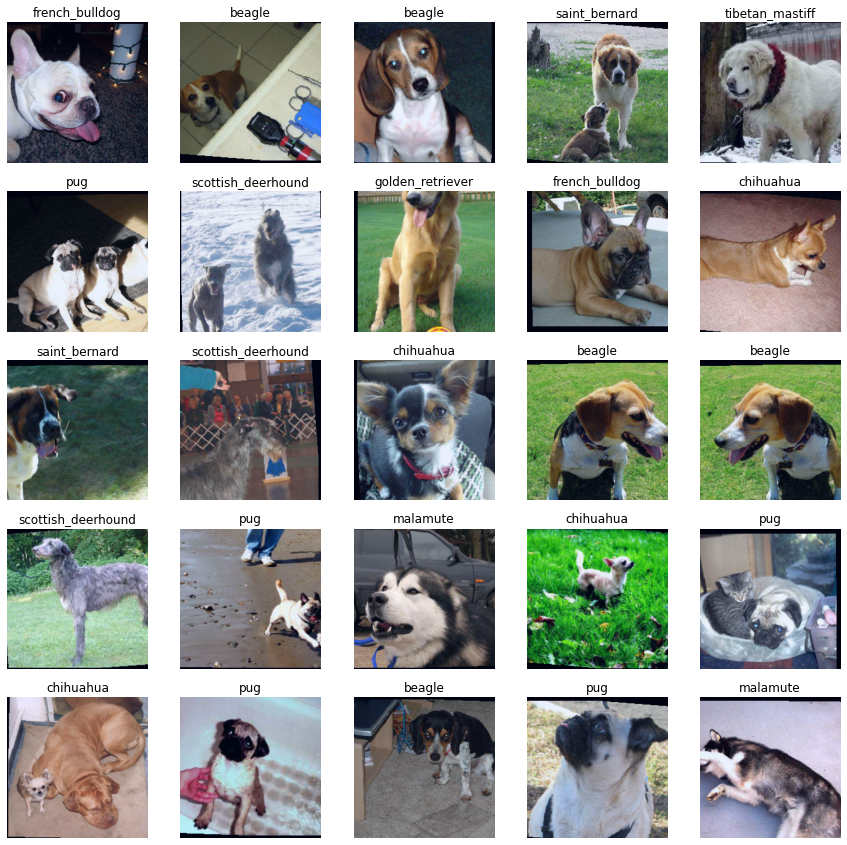

In [14]:
import random

N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[random.randint(0, len(train_data)-1)] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

### Defining the Model

In [15]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)
        
        return x, h

In [16]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        
        self.relu = nn.ReLU(inplace = True)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x)
    
        return x

In [17]:
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

In [18]:
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

In [19]:
pretrained_model = models.resnet50(pretrained = True)

In [20]:
print(pretrained_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [21]:
IN_FEATURES = pretrained_model.fc.in_features 
OUTPUT_DIM = len(dog_breeds)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)

In [22]:
pretrained_model.fc = fc

In [23]:
model = ResNet(resnet50_config, OUTPUT_DIM)

In [24]:
model.load_state_dict(pretrained_model.state_dict())

<All keys matched successfully>

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,528,522 trainable parameters


### Training the Model

Next we'll move on to training our model. We'll use the learning rate finder to set a suitable learning rate for our model.

In [36]:
START_LR = 1e-7

optimizer = optim.Adam(model.parameters(), lr=START_LR)

device = torch.device('cpu')

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

The code below is taken from [pytorch-lr-finder](https://github.com/davidtvs/pytorch-lr-finder).

In [37]:
class LRFinder:
    def __init__(self, model, optimizer, criterion, device):
        
        self.optimizer = optimizer
        self.model = model
        self.criterion = criterion
        self.device = device
        
        torch.save(model.state_dict(), 'init_params.pt')

    def range_test(self, iterator, end_lr = 10, num_iter = 100, 
                   smooth_f = 0.05, diverge_th = 5):
        
        lrs = []
        losses = []
        best_loss = float('inf')

        lr_scheduler = ExponentialLR(self.optimizer, end_lr, num_iter)
        
        iterator = IteratorWrapper(iterator)
        
        for iteration in range(num_iter):

            loss = self._train_batch(iterator)

            #update lr
            lr_scheduler.step()
            
            lrs.append(lr_scheduler.get_lr()[0])

            if iteration > 0:
                loss = smooth_f * loss + (1 - smooth_f) * losses[-1]
                
            if loss < best_loss:
                best_loss = loss

            losses.append(loss)
            
            if loss > diverge_th * best_loss:
                print("Stopping early, the loss has diverged")
                break
                       
        #reset model to initial parameters
        model.load_state_dict(torch.load('init_params.pt'))
                    
        return lrs, losses

    def _train_batch(self, iterator):
        
        self.model.train()
        
        self.optimizer.zero_grad()
        
        x, y = iterator.get_batch()
        
        x = x.to(self.device)
        y = y.to(self.device)
        
        y_pred, _ = self.model(x)
                
        loss = self.criterion(y_pred, y)
        
        loss.backward()
        
        self.optimizer.step()
        
        return loss.item()

class ExponentialLR(_LRScheduler):
    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]

class IteratorWrapper:
    def __init__(self, iterator):
        self.iterator = iterator
        self._iterator = iter(iterator)

    def __next__(self):
        try:
            inputs, labels = next(self._iterator)
        except StopIteration:
            self._iterator = iter(self.iterator)
            inputs, labels, *_ = next(self._iterator)

        return inputs, labels

    def get_batch(self):
        return next(self)

In [129]:
END_LR = 10
NUM_ITER = 50

lr_finder = LRFinder(model, optimizer, criterion, device)
lrs, losses = lr_finder.range_test(train_iterator, END_LR, NUM_ITER)

Stopping early, the loss has diverged


In [125]:
def plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5):
    
    if skip_end == 0:
        lrs = lrs[skip_start:]
        losses = losses[skip_start:]
    else:
        lrs = lrs[skip_start:-skip_end]
        losses = losses[skip_start:-skip_end]
    
    fig = plt.figure(figsize = (16,8))
    ax = fig.add_subplot(1,1,1)
    ax.plot(lrs, losses)
    ax.set_xscale('log')
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('Loss')
    ax.grid(True, 'both', 'x')
    plt.show()

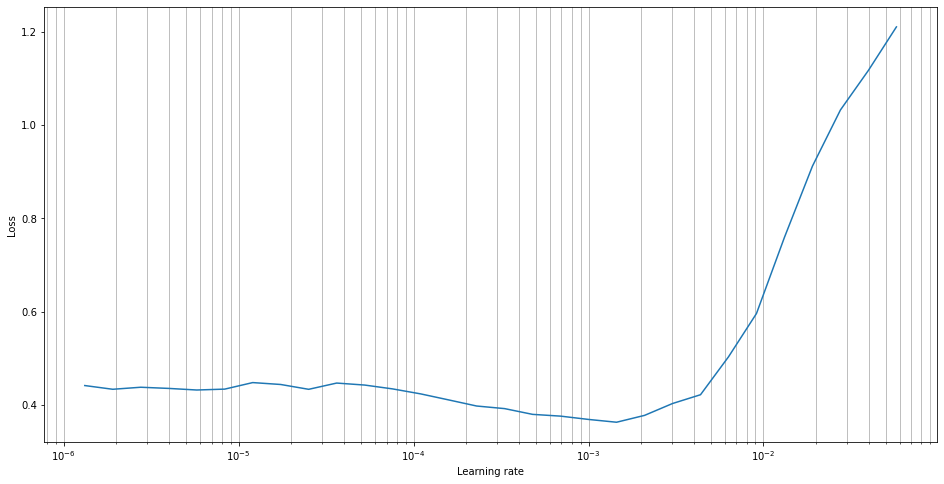

In [130]:
plot_lr_finder(lrs, losses, skip_start = 5, skip_end = 5)

In [38]:
LR = 1e-3

params = [
          {'params': model.conv1.parameters(), 'lr': LR / 10},
          {'params': model.bn1.parameters(), 'lr': LR / 10},
          {'params': model.layer1.parameters(), 'lr': LR / 8},
          {'params': model.layer2.parameters(), 'lr': LR / 6},
          {'params': model.layer3.parameters(), 'lr': LR / 4},
          {'params': model.layer4.parameters(), 'lr': LR / 2},
          {'params': model.fc.parameters()}
         ]


optimizer = optim.Adam(params, lr = LR)

In [39]:
EPOCHS = 5
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [40]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [41]:
def train_model(model, iterator, optimizer, criterion, scheduler, device):
    
    epoch_acc = 0
    epoch_loss = 0
    
    model.train()
    
    for x,y in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        y_pred, _ = model(x)
        
        loss = criterion(y_pred,y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        scheduler.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [42]:
def evaluate_model(model, iterator, criterion, device):
    
    epoch_acc = 0
    epoch_loss = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for x,y in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred,y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)       

In [43]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [44]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc = evaluate_model(model, valid_iterator, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 9m 15s
	Train Loss: 1.373 | Train Acc: 64.28%
	 Val. Loss: 0.276 |  Val. Acc: 90.72%
Epoch: 02 | Epoch Time: 8m 52s
	Train Loss: 0.389 | Train Acc: 88.25%
	 Val. Loss: 0.440 |  Val. Acc: 82.86%
Epoch: 03 | Epoch Time: 8m 40s
	Train Loss: 0.274 | Train Acc: 92.41%
	 Val. Loss: 0.370 |  Val. Acc: 88.64%
Epoch: 04 | Epoch Time: 8m 30s
	Train Loss: 0.117 | Train Acc: 96.16%
	 Val. Loss: 0.296 |  Val. Acc: 87.69%
Epoch: 05 | Epoch Time: 8m 28s
	Train Loss: 0.099 | Train Acc: 97.78%
	 Val. Loss: 0.279 |  Val. Acc: 89.68%
